# Лабораторная работа №5. Машинное обучение

## 1. Анализ и предобработка данных

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

In [ ]:
movies = pd.read_csv('./mkrf_movies.csv')
shows = pd.read_csv('./mkrf_shows.csv')

In [129]:
movies.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"


In [130]:
movies.describe()

,refundable_support,nonrefundable_support,budget
count,3.320000e+02,3.320000e+02,3.320000e+02
mean,1.186446e+07,4.898099e+07,1.272297e+08
std,2.491656e+07,5.998012e+07,1.885883e+08
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.500000e+07,4.200000e+07
50%,0.000000e+00,3.000000e+07,6.864992e+07
75%,1.500000e+07,4.037500e+07,1.419853e+08
max,1.800000e+08,4.000000e+08,2.305074e+09


In [131]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [132]:
shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


### Объединение датасетов

При подготовке к объединению двух датасетов было найдено одно значение "нет" в puNumber, которое заменено на 0. В таблице movies значения в puNumber были строкового типа, поэтому перед объединением они были преобразованы в числа.

In [133]:
movies['puNumber'] = pd.to_numeric(movies['puNumber'], errors='coerce')
movies['puNumber'] = movies['puNumber'].fillna(0)
movies['puNumber'] = movies['puNumber'].astype(int)

In [134]:
data = pd.merge(movies, shows, on='puNumber', how='left')  # how='left' чтобы сохранить все строки из df1

print(data.shape)
print(data.columns)

(7486, 16)
Index(['title', 'puNumber', 'show_start_date', 'type', 'film_studio',
       'production_country', 'director', 'producer', 'age_restriction',
       'refundable_support', 'nonrefundable_support', 'budget',
       'financing_source', 'ratings', 'genres', 'box_office'],
      dtype='object')


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   int64  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

### Анализ дубликатов

In [136]:
data['title'].value_counts().head()

,count
title,
День святого Валентина_,5
Дом грёз,4
Знакомство с Факерами 2.,4
Начало_,4
Дитя тьмы,4


In [137]:
duplicate_titles = data['title'].value_counts()
duplicate_titles = duplicate_titles[duplicate_titles > 1].index

duplicates = data[data['title'].isin(duplicate_titles)]

Тут сначала находим в таблице дубликаты по критерию совпадения названия фильма, потом сравниваем эти дубликаты на предмет совпадения значений других признаков. Если совпадают значения более 7 признаков, то считаем, что это один и тот же фильм. В итоге оставляем только одну запись о фильме, сохранив при этом как можно больше информации, то есть взяв от двух дубликатов все доступные значения признаков.

In [138]:
data['title'] = (
    data['title']
    .astype(str)
    .str.strip()
    .str.strip('._')
    .str.lower()
)

grouped = data.groupby('title')
final_rows = []
comparison_columns = [col for col in data.columns if col != 'title']

def count_matches(row1, row2):
    return sum((row1[col] == row2[col]) or pd.isna(row1[col]) or pd.isna(row2[col]) for col in comparison_columns)

def merge_rows(row1, row2):
    return [row1[col] if pd.notna(row1[col]) else row2[col] for col in data.columns]

for title, group in grouped:
    group = group.reset_index(drop=True)
    used = set()
    for i in range(len(group)):
        if i in used:
            continue
        row = group.loc[i]
        for j in range(i + 1, len(group)):
            if j in used:
                continue
            other_row = group.loc[j]
            if count_matches(row, other_row) >= 7:
                row = pd.Series(merge_rows(row, other_row), index=data.columns)
                used.add(j)
        final_rows.append(row)

data = pd.DataFrame(final_rows)
data.shape

(6686, 16)

### Обработка show_start_date

In [139]:
data['show_start_date'].value_counts()

,count
show_start_date,
2014-12-01T12:00:00.000Z,71
2010-12-17T12:00:00.000Z,64
2014-12-24T12:00:00.000Z,60
2013-12-19T12:00:00.000Z,38
2016-06-07T12:00:00.000Z,36
...,...
2017-09-15T12:00:00.000Z,1
2010-02-04T12:00:00.000Z,1
2010-05-07T12:00:00.000Z,1


In [140]:
show_start_date = pd.to_datetime(data['show_start_date'], errors='coerce')

data['year'] = show_start_date.dt.year
data['month'] = show_start_date.dt.month
data['weekday'] = show_start_date.dt.weekday
data['day'] = show_start_date.dt.day
data['timestamp'] = show_start_date.astype('int64') // 10**9

### Обработка type

In [141]:
data['type'].value_counts()

,count
type,
Художественный,3878
Художественный,1333
Анимационный,757
Прочие,389
Документальный,275
Научно-популярный,52
Музыкально-развлекательный,1
Анимационный,1


In [142]:
data['type'] = data['type'].str.strip().str.lower()
data['type'] = data['type'].replace('музыкально-развлекательный', 'прочие')
data = pd.get_dummies(data, columns=['type'], prefix='type', dtype=int)

### Обработка film_studio

In [143]:
data['film_studio'].value_counts()

,count
film_studio,
"Киностудия ""Мосфильм""",335
"ООО ""Мульт в кино""",57
Анимаккорд Лтд,23
"ООО ""Мульт в кино""",18
"ФГУП ""ТПО ""Киностудия ""Союзмультфильм""",15
...,...
"Сосьете Нувель де Синематографи, СиДжиИСи, Компанья Дженерале Финанциарья Чинематографика",1
"Дэйт Авейтс Синема, Пинк Буффало Филмз",1
Диджитал Интерференс,1


Выделим 20 самых продуктивных студий (которые выпустили больше всего фильмов), остальные закодируем как "другие"

In [144]:
data['film_studio'] = data['film_studio'].str.strip().str.lower()
data['film_studio'] = data['film_studio'].fillna('')

TOP_N = 20
top_studios = data['film_studio'].value_counts().nlargest(TOP_N).index

data['film_studio_limited'] = data['film_studio'].apply(lambda x: x if x in top_studios else 'другая студия')

studio_ohe = pd.get_dummies(data['film_studio_limited'], prefix='studio', dtype=int)
data = pd.concat([data, studio_ohe], axis=1)

### Обработка production_country

In [145]:
data['production_country'].value_counts()

,count
production_country,
Россия,1780
США,1739
СССР,339
Франция,274
Великобритания,240
...,...
Республика Кипр-Россия,1
США-Канада-Бельгия,1
Бразилия - Португалия - Франция,1


Страны закодируем таким образом, что если какая-то страна принимала участие в создании фильма, что в столбце с этой страной будет стоять 1, иначе 0. Так можно учесть, что фильм могли делать представители одной страны или нескольких

Кроме того, относительно небольшое количество стран позволило сделать качественную обработку, например, заменить опечатки и прочее

In [146]:
data['country_list'] = (
    data['production_country']
    .fillna('')
    .str.replace(r'[-–—]', ',', regex=True)
    .str.replace(r'\s*,\s*', ',', regex=True)
    .str.strip()
    .apply(lambda x: [i.strip().lower() for i in x.split(',') if i.strip()])
)

country_aliases = {
    'англия': 'великобритания',
    'белоруссия': 'беларусь', 'республика беларусь': 'беларусь',
    'бенльгия': 'бельгия',
    'босния': 'босния и герцеговина', 'герцеговина': 'босния и герцеговина',
    'внр': 'венгрия',
    'гдр': 'германия', 'германя': 'германия', 'западный берлин': 'германия', 'фрг': 'германия',
    'изриль': 'израиль',
    'к;анада': 'канада',
    'кнр': 'китай',
    'ланка': 'шри-ланка', 'шри': 'шри-ланка',
    'н.зеландия': 'новая зеландия',
    'норвения': 'норвегия',
    'объединенные арабские эмираты': 'оаэ',
    'пнр': 'польша',
    'порртугалия': 'португалия',
    'пуэрто': 'пуэрто рико', 'рико': 'пуэрто рико',
    'ю.корея': 'южная корея', 'корея': 'южная корея', 'республика корея': 'южная корея',
    'республика армения': 'армения',
    'республика казахстан': 'казахстан',
    'республика кипр': 'кипр',
    'сща': 'сша',
    'фрация': 'франция',
    'чехословакия': 'чехия', 'чехшская республика': 'чехия',
    'чсср': 'ссср',
}

In [147]:
data['country_list'] = data['country_list'].apply(lambda country_list: [
    country_aliases.get(c.strip().lower(), c.strip().lower())
    for c in country_list if c.strip() and c.strip().lower() not in ['nan', 'none']
])

all_countries = data['country_list'].explode()
top_20 = all_countries.value_counts().head(20).index.tolist()

data['country_list_limited'] = data['country_list'].apply(lambda countries:
    [c if c in top_20 else 'другие страны' for c in countries]
)

In [148]:
mlb = MultiLabelBinarizer(classes=top_20)
one_hot_encoded = mlb.fit_transform(data['country_list_limited'])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_, index=data.index)

one_hot_df.columns = ['country_' + col for col in one_hot_df.columns]
data = pd.concat([data.reset_index(drop=True), one_hot_df.reset_index(drop=True)], axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['другие страны'] will be ignored
  warnings.warn(


### Обработка director

In [149]:
data['director'].value_counts()

,count
director,
О.Семёнова,47
Д.Червяцов,16
Вуди Аллен,13
О.Семёнова,12
Стивен Содерберг,12
...,...
Сиддхартх Малхотра,1
Р.Д. Браунштейн,1
Г.Коломийцев,1


In [150]:
data['director'] = data['director'].astype(str).str.strip().str.lower()
data['director'] = data['director'].fillna('другой режиссёр')

TOP_N_DIRECTORS = 20
top_directors = data['director'].value_counts().nlargest(TOP_N_DIRECTORS).index

data['director_limited'] = data['director'].apply(lambda x: x if x in top_directors else 'другой режиссёр')
director_ohe = pd.get_dummies(data['director_limited'], prefix='director', dtype=int, drop_first=True)

data = pd.concat([data, director_ohe], axis=1)

С режиссерами поступим так же, как со студиями - выявим 20 наиболее популярных значений, остальные закодируем как "другие"

### Обработка producer

In [151]:
data['producer'].value_counts()

,count
producer,
П.Смирнов,67
"Олег Кузовков, Дмитрий Ловейко, Марина Ратина",28
С.Сельянов,18
"Д.Ловейко, О.Кузовков",16
Кевин Фейги,11
...,...
"Жан-Клод Ван Дамм, Эвзен Килар",1
"Дж.Д. Лифшиц, Рафаэль Маргулес",1
"Эрик Инглэнд, Дж.Д. Лифшиц, Рафаэль Маргулес",1


In [152]:
data['producer'] = data['producer'].astype(str).str.strip().str.lower()
data['producer'] = data['producer'].fillna('другой продюсер')

TOP_N_PRODUCERS = 20
top_producers = data['producer'].value_counts().nlargest(TOP_N_PRODUCERS).index

data['producer_limited'] = data['producer'].apply(lambda x: x if x in top_producers else 'другой продюсер')
producer_ohe = pd.get_dummies(data['producer_limited'], prefix='producer', dtype=int, drop_first=True)

data = pd.concat([data, producer_ohe], axis=1)

### Обработка age_restriction

In [153]:
data['age_restriction'].value_counts()

,count
age_restriction,
«16+» - для детей старше 16 лет,2477
«12+» - для детей старше 12 лет,1468
«18+» - запрещено для детей,1410
«0+» - для любой зрительской аудитории,734
«6+» - для детей старше 6 лет,597


In [154]:
data['age_cleaned'] = (
    data['age_restriction']
    .fillna('')
    .str.extract(r'(\d+\+)', expand=False)
)

age_dummies = pd.get_dummies(data['age_cleaned'], prefix='age', dtype=int)
data = pd.concat([data, age_dummies], axis=1)

### Обработка financing_source

In [155]:
data['financing_source'].value_counts()

,count
financing_source,
Министерство культуры,164
Фонд кино,146
"Министерство культуры, Фонд кино",22


In [156]:
data['financing_list'] = (
    data['financing_source']
    .fillna('')
    .str.replace(r'\s*,\s*', ',', regex=True)
    .str.strip()
    .apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])
)

financing_dummies = data['financing_list'].explode().str.get_dummies().groupby(level=0).sum()
financing_dummies.columns = ['financing_source_mincult', 'financing_source_fond_kino']

data = pd.concat([data, financing_dummies], axis=1)

### Обработка genres

In [157]:
data['genres'].value_counts()

,count
genres,
драма,441
комедия,329
"мелодрама,комедия",177
"драма,мелодрама",169
"драма,мелодрама,комедия",161
...,...
"детский,мультфильм,приключения",1
"драма,история,детектив",1
"боевик,комедия,семейный",1


С жанрами такая же логика, как была со странами

In [158]:
from collections import Counter

data['genre_list'] = (
    data['genres']
    .fillna('')
    .str.replace(r'[-–—]', ',', regex=True)
    .str.replace(r'\s*,\s*', ',', regex=True)
    .str.strip()
    .apply(lambda x: [i.strip().lower() for i in x.split(',') if i.strip() and i != 'nan'])
)

all_genres = data['genre_list'].explode()
genre_counts = Counter(all_genres)

min_count = 2
rare_genres = {genre for genre, count in genre_counts.items() if count < min_count}

def replace_rare_genres(genres):
    return [g if g not in rare_genres else 'другой жанр' for g in genres]

data['genre_list_limited'] = data['genre_list'].apply(replace_rare_genres)
genre_dummies = data['genre_list_limited'].explode().str.get_dummies().groupby(level=0).sum()
genre_dummies = genre_dummies.add_prefix('genres_')

data = pd.concat([data, genre_dummies], axis=1)

К категории "другие жанры" относятся фильмы, у которых значение признака не указано (nan), а также реальное тв и новости

### Обработка пропусков в ratings и box_office

In [159]:
data['ratings'] = (
    data['ratings']
    .astype(str)
    .str.strip()
    .str.replace(',', '.', regex=False)
)

data['ratings'] = pd.to_numeric(data['ratings'], errors='coerce')

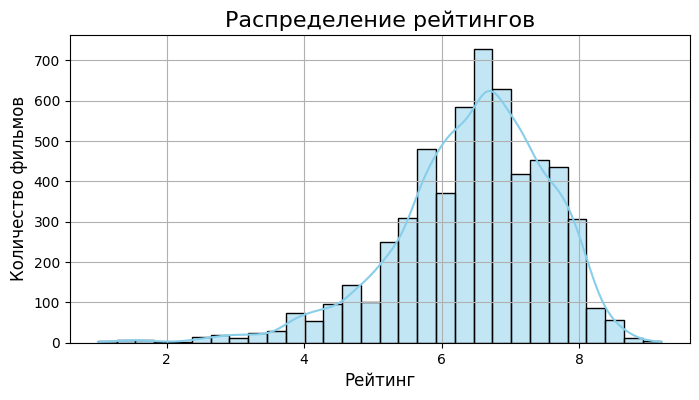

In [160]:
plt.figure(figsize=(8, 4))
sns.histplot(data['ratings'].dropna(), bins=30, kde=True, color='skyblue')

plt.title('Распределение рейтингов', fontsize=16)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Количество фильмов', fontsize=12)
plt.grid(True)
plt.show()


Пропуски в значении рейтинга заменим медианным значением

In [161]:
median_rating = data['ratings'].median()
data['ratings'] = data['ratings'].fillna(median_rating)

В box_office заменим пропуски на 0, так как, предположительно, если у фильма нет значения кассовых сборов, то соответственно в кинотеатрах его скорее всего не показывали

In [162]:
data['box_office'] = data['box_office'].fillna(0)

In [163]:
info_df = pd.DataFrame({
    'column': data.columns,
    'dtype': data.dtypes,
    'missing_pct': data.isnull().mean() * 100
}).reset_index(drop=True)

info_df['missing_pct'] = info_df['missing_pct'].round(2)
print(info_df)

                 column   dtype  missing_pct
0                 title  object         0.00
1              puNumber   int64         0.00
2       show_start_date  object         0.00
3           film_studio  object         0.00
4    production_country  object         0.03
..                  ...     ...          ...
146      genres_триллер   int64         0.00
147        genres_ужасы   int64         0.00
148   genres_фантастика   int64         0.00
149        genres_фильм   int64         0.00
150      genres_фэнтези   int64         0.00

[151 rows x 3 columns]


In [164]:
features = [
    'ratings',
    'box_office',
    'year', 'month', 'weekday', 'day',
    'type_анимационный', 'type_документальный', 'type_научно-популярный', 'type_прочие', 'type_художественный',
    'studio_', 'studio_анимаккорд лтд', 'studio_дримуоркс анимейшн', 'studio_другая студия', 'studio_зао "аэроплан"', 'studio_киностудия "мосфильм"',
    'studio_оао "тпо "санкт-петербургская студия документальных фильмов"', 'studio_ооо "кинокомпания "ств"', 'studio_ооо "мульт в кино"',
    'studio_ооо "продюсерский центр ералаш"', 'studio_ооо "студия анимационного кино "мельница"', 'studio_ооо "таббак"', 'studio_ооо "энджой мувиз"', 'studio_опус арте',
    'studio_пиксар анимейшн студиос, уолт дисней пикчерз', 'studio_р а и синема', 'studio_свердловская киностудия', 'studio_синема лайв', 'studio_уорнер бразерс',
    'studio_фгуп "тпо "киностудия "союзмультфильм"', 'studio_эр а и синема',
    'country_сша', 'country_россия', 'country_франция', 'country_великобритания', 'country_германия', 'country_ссср', 'country_италия', 'country_канада',
    'country_бельгия', 'country_испания', 'country_австралия', 'country_китай', 'country_япония', 'country_дания', 'country_швеция', 'country_кипр',
    'country_нидерланды','country_ирландия', 'country_индия', 'country_норвегия',
    'director_вуди аллен', 'director_георгий орлов', 'director_д.дьяченко', 'director_д.червяцов', 'director_другой режиссёр', 'director_квентин тарантино', 'director_клинт иствуд',
    'director_кристофер нолан', 'director_л.гайдай','director_люк бессон', 'director_н.михалков', 'director_о.семёнова', 'director_п.смирнов', 'director_питер джексон',
    'director_ридли скотт', 'director_роберт земекис', 'director_роберт родригес', 'director_с.андреасян', 'director_стивен содерберг', 'director_стивен спилберг',
    'producer_а.герасимов', 'producer_а.тельнов', 'producer_а.учитель, к.саксаганская', 'producer_б.машковцев, с.струсовский', 'producer_г.васильев, м.мэннис, и.попов',
    'producer_д.ловейко, о.кузовков', 'producer_джерри брукхаймер', 'producer_другой продюсер', 'producer_и.гелашвили', 'producer_кевин фейги', 'producer_н.мокрицкая',
    'producer_олег кузовков, дмитрий ловейко, марина ратина', 'producer_ооо "продюсерский центр ералаш"', 'producer_п.смирнов', 'producer_с.говорухин, е.маскина',
    'producer_с.сельянов', 'producer_с.сельянов, а.боярский', 'producer_фгуп "киноконцерн "мосфильм"', 'producer_фил грабски', 'producer_э.пичугин',
    'age_0+', 'age_12+', 'age_16+', 'age_18+', 'age_6+',
    'financing_source_mincult', 'financing_source_fond_kino',
    'genres_аниме', 'genres_биография', 'genres_боевик', 'genres_вестерн', 'genres_военный', 'genres_детектив', 'genres_детский', 'genres_для взрослых', 'genres_документальный',
    'genres_драма', 'genres_другой жанр', 'genres_история', 'genres_комедия', 'genres_концерт', 'genres_короткометражка', 'genres_криминал', 'genres_мелодрама',
    'genres_музыка', 'genres_мультфильм', 'genres_мюзикл', 'genres_нуар', 'genres_приключения', 'genres_семейный', 'genres_спорт', 'genres_триллер', 'genres_ужасы',
    'genres_фантастика', 'genres_фильм','genres_фэнтези'
]


In [165]:
data = data[features]

### Скалирование

Скалируем только box_office, так как все остальные признаки и так представлены собственно в диапазоне от 0 до 1

In [166]:
scaler = StandardScaler()
data['box_office'] = scaler.fit_transform(data[['box_office']])

<ipython-input-166-a9e76a75e1a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['box_office'] = scaler.fit_transform(data[['box_office']])


## 2. baseline

In [167]:
class MovieRatingNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super(MovieRatingNN, self).__init__()
        layers = []
        prev_dim = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h

        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [168]:
def train_model(X, y, hidden_dims=[64, 32], lr=1e-3, epochs=100, batch_size=64):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)

    model = MovieRatingNN(input_dim=X.shape[1], hidden_dims=hidden_dims)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    return model, X_test_t, y_test_t


target = 'ratings'
features = data.select_dtypes(include=['int64', 'float64']).drop(columns=[target])

model, X_test_t, y_test_t = train_model(features, data[target], hidden_dims=[128, 64], epochs=300)

Epoch 10/300, Loss: 0.7227
Epoch 20/300, Loss: 0.5153
Epoch 30/300, Loss: 0.5820
Epoch 40/300, Loss: 0.7271
Epoch 50/300, Loss: 0.7662
Epoch 60/300, Loss: 0.2960
Epoch 70/300, Loss: 1.2562
Epoch 80/300, Loss: 0.6846
Epoch 90/300, Loss: 0.4025
Epoch 100/300, Loss: 0.4507
Epoch 110/300, Loss: 0.4657
Epoch 120/300, Loss: 0.2665
Epoch 130/300, Loss: 0.3776
Epoch 140/300, Loss: 0.2705
Epoch 150/300, Loss: 0.4345
Epoch 160/300, Loss: 0.5986
Epoch 170/300, Loss: 0.2132
Epoch 180/300, Loss: 0.3582
Epoch 190/300, Loss: 0.2232
Epoch 200/300, Loss: 0.2338
Epoch 210/300, Loss: 0.3068
Epoch 220/300, Loss: 0.2539
Epoch 230/300, Loss: 0.3024
Epoch 240/300, Loss: 0.4679
Epoch 250/300, Loss: 0.5380
Epoch 260/300, Loss: 0.3032
Epoch 270/300, Loss: 0.1888
Epoch 280/300, Loss: 0.4443
Epoch 290/300, Loss: 0.2172
Epoch 300/300, Loss: 0.3677


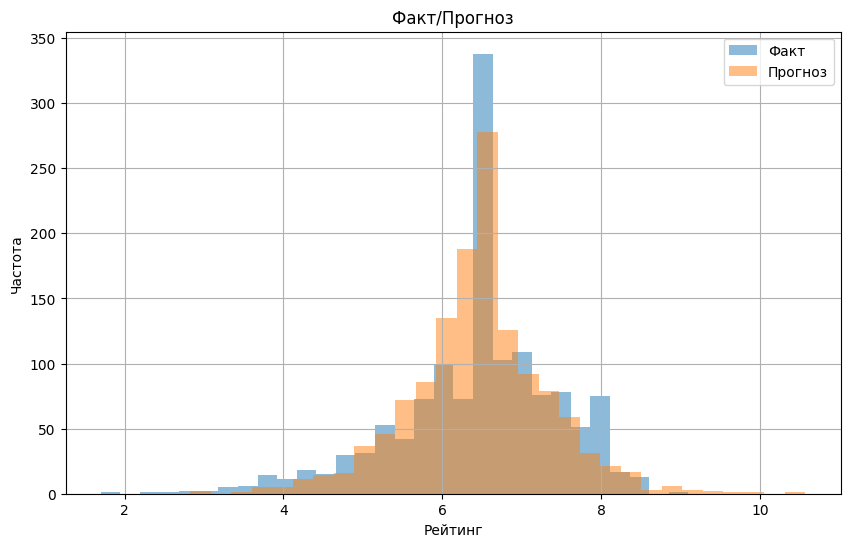

In [169]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).squeeze()

plt.figure(figsize=(10, 6))
plt.hist(y_test_t, bins=30, alpha=0.5, label='Факт')
plt.hist(y_pred, bins=30, alpha=0.5, label='Прогноз')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.title('Факт/Прогноз')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Таким образом, loss в целом снижается, что свидетельствует о хорошей работе модели. Однако значение loss довольно сильно колеблется от эпохи к эпохе - попробуем это исправить

In [170]:
class MovieRatingImprovedNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], activation=nn.ReLU, dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(activation())
            layers.append(nn.Dropout(dropout))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_with_validation(X, y, lr=1e-4, batch_size=128, epochs=100):
    # Train / Val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_t = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)


    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)

    model = MovieRatingImprovedNN(input_dim=X.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = loss_fn(val_pred, y_val_t).item()
            train_pred = model(X_train_t)
            train_loss = loss_fn(train_pred, y_train_t).item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model, train_losses, val_losses

Epoch 1/300, Train Loss: 42.2398, Val Loss: 42.0877
Epoch 10/300, Train Loss: 29.9939, Val Loss: 30.0987
Epoch 20/300, Train Loss: 19.1510, Val Loss: 19.2447
Epoch 30/300, Train Loss: 10.2273, Val Loss: 10.2653
Epoch 40/300, Train Loss: 4.6413, Val Loss: 4.6717
Epoch 50/300, Train Loss: 2.1404, Val Loss: 2.1887
Epoch 60/300, Train Loss: 1.2866, Val Loss: 1.3647
Epoch 70/300, Train Loss: 1.0698, Val Loss: 1.1759
Epoch 80/300, Train Loss: 0.9330, Val Loss: 1.0590
Epoch 90/300, Train Loss: 0.9251, Val Loss: 1.0614
Epoch 100/300, Train Loss: 0.8907, Val Loss: 1.0398
Epoch 110/300, Train Loss: 0.8518, Val Loss: 1.0127
Epoch 120/300, Train Loss: 0.8513, Val Loss: 1.0162
Epoch 130/300, Train Loss: 0.8203, Val Loss: 0.9936
Epoch 140/300, Train Loss: 0.8078, Val Loss: 0.9866
Epoch 150/300, Train Loss: 0.8030, Val Loss: 0.9846
Epoch 160/300, Train Loss: 0.7657, Val Loss: 0.9574
Epoch 170/300, Train Loss: 0.7409, Val Loss: 0.9381
Epoch 180/300, Train Loss: 0.7305, Val Loss: 0.9315
Epoch 190/300, 

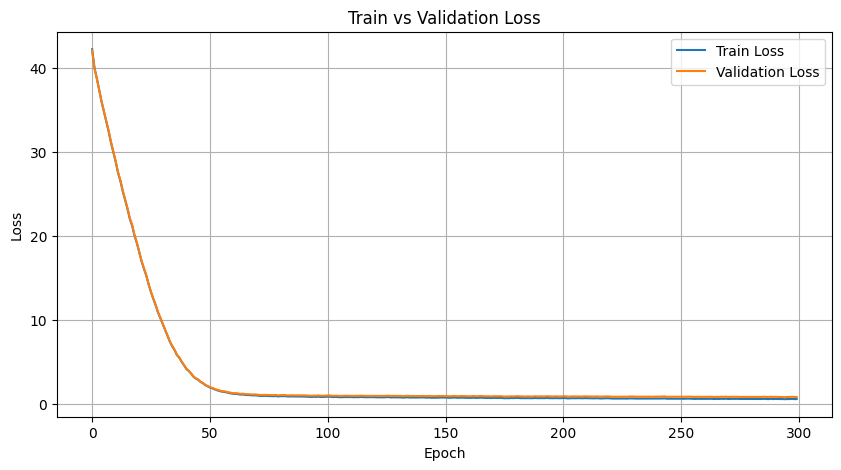

In [171]:
model, train_losses, val_losses = train_with_validation(features, data['ratings'], epochs=300)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Теперь модель стала более стабильной, loss уменьшается постепенно, хотя кажется имеется небольшое переобучение, судя по отличиям между трейновым и валидационным значением loss

## 3. Улучшение нейросети

In [173]:
class MovieRatingNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], activation=nn.ReLU, dropout=0.0, use_bn=False):
        super().__init__()
        layers = []
        prev_dim = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            if use_bn:
                layers.append(nn.BatchNorm1d(h))
            layers.append(activation())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [174]:
def train_and_evaluate(X, y, activation_fn, dropout, use_bn, batch_size, epochs=100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)

    model = MovieRatingNN(input_dim=X.shape[1],
                          activation=activation_fn,
                          dropout=dropout,
                          use_bn=use_bn)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).numpy().flatten()
        true_vals = y_test_t.numpy().flatten()
        rmse = np.sqrt(mean_squared_error(true_vals, preds))
    return rmse, preds, true_vals

In [175]:
param_grid = {
    'activation_fn': [nn.ReLU, nn.Tanh],
    'dropout': [0.0, 0.3],
    'use_bn': [False, True],
    'batch_size': [32, 64]
}

results = []
for act_fn in param_grid['activation_fn']:
    for dr in param_grid['dropout']:
        for bn in param_grid['use_bn']:
            for bs in param_grid['batch_size']:
                rmse, preds, y_true = train_and_evaluate(
                    features, data['ratings'],
                    activation_fn=act_fn,
                    dropout=dr,
                    use_bn=bn,
                    batch_size=bs,
                    epochs=100
                )
                results.append({
                    'activation': act_fn.__name__,
                    'dropout': dr,
                    'batch_norm': bn,
                    'batch_size': bs,
                    'rmse': rmse,
                    'preds': preds,
                    'y_true': y_true
                })
                print(f"Done: {act_fn.__name__}, Dropout={dr}, BN={bn}, BS={bs}, RMSE={rmse:.4f}")

Done: ReLU, Dropout=0.0, BN=False, BS=32, RMSE=0.9578
Done: ReLU, Dropout=0.0, BN=False, BS=64, RMSE=0.9523
Done: ReLU, Dropout=0.0, BN=True, BS=32, RMSE=0.9286
Done: ReLU, Dropout=0.0, BN=True, BS=64, RMSE=0.9607
Done: ReLU, Dropout=0.3, BN=False, BS=32, RMSE=0.8877
Done: ReLU, Dropout=0.3, BN=False, BS=64, RMSE=0.8795
Done: ReLU, Dropout=0.3, BN=True, BS=32, RMSE=0.8743
Done: ReLU, Dropout=0.3, BN=True, BS=64, RMSE=0.9028
Done: Tanh, Dropout=0.0, BN=False, BS=32, RMSE=0.8994
Done: Tanh, Dropout=0.0, BN=False, BS=64, RMSE=0.8970
Done: Tanh, Dropout=0.0, BN=True, BS=32, RMSE=0.9354
Done: Tanh, Dropout=0.0, BN=True, BS=64, RMSE=0.9295
Done: Tanh, Dropout=0.3, BN=False, BS=32, RMSE=0.8892
Done: Tanh, Dropout=0.3, BN=False, BS=64, RMSE=0.8931
Done: Tanh, Dropout=0.3, BN=True, BS=32, RMSE=0.8547
Done: Tanh, Dropout=0.3, BN=True, BS=64, RMSE=0.8641


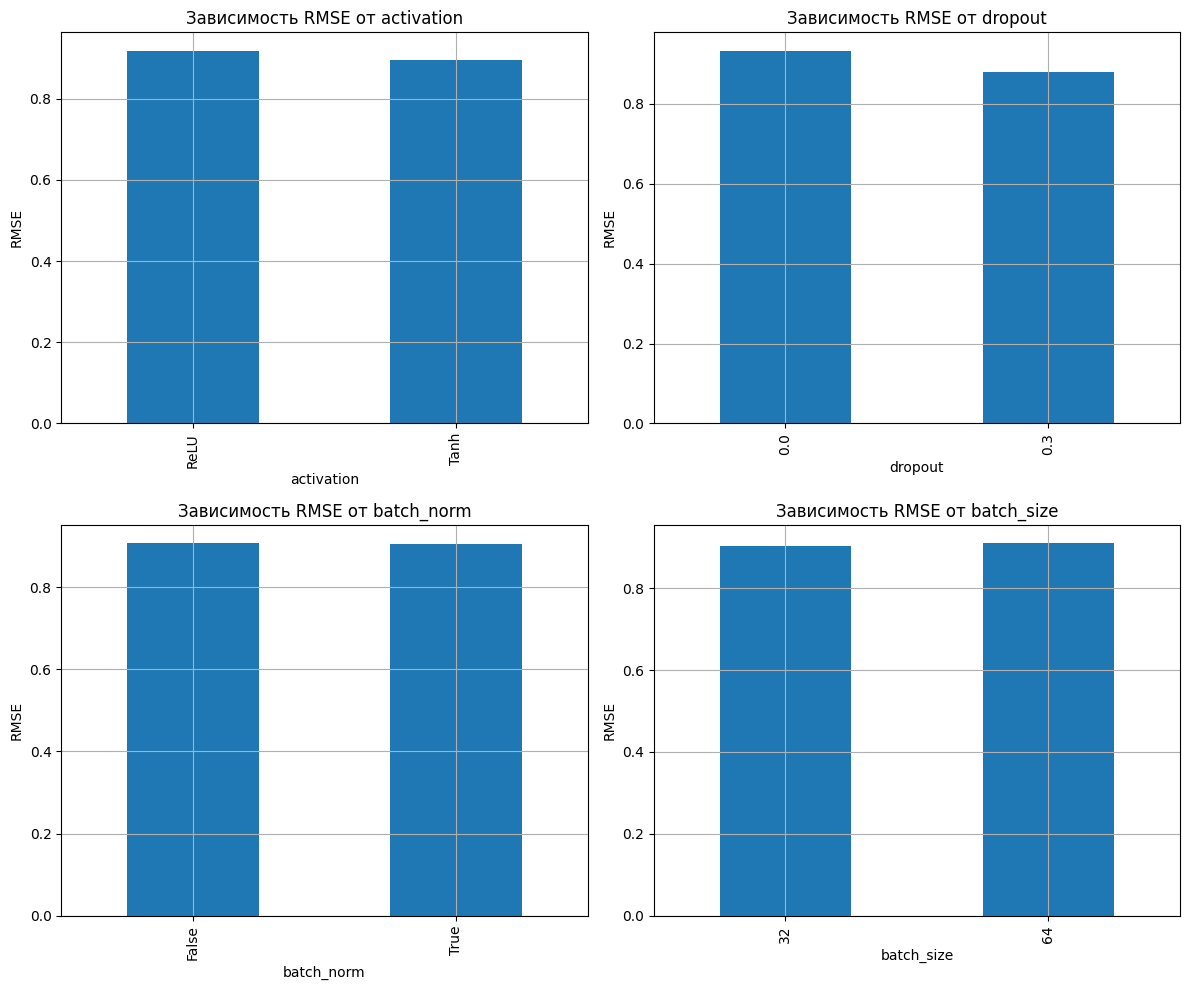

In [176]:
results_df = pd.DataFrame([{k: v for k, v in res.items() if k not in ['preds', 'y_true']} for res in results])

keys = ['activation', 'dropout', 'batch_norm', 'batch_size']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, key in enumerate(keys):
    results_df.groupby(key)['rmse'].mean().plot(kind='bar', ax=axs[i])
    axs[i].set_title(f'Зависимость RMSE от {key}')
    axs[i].set_ylabel('RMSE')
    axs[i].set_xlabel(key)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

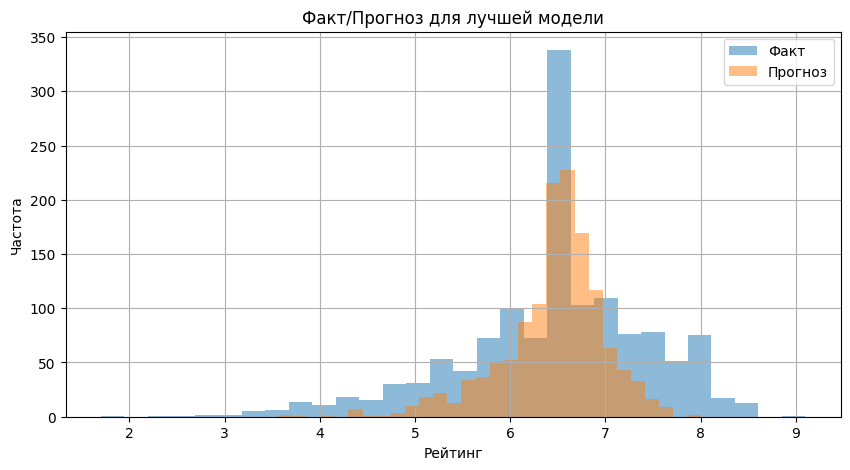

{'activation': 'Tanh', 'dropout': 0.3, 'batch_norm': True, 'batch_size': 32, 'rmse': np.float64(0.8547002746073677), 'preds': array([6.409355 , 6.468011 , 6.3226876, ..., 6.932128 , 7.308689 ,
       6.3559847], dtype=float32), 'y_true': array([6.6, 6.6, 7.3, ..., 6.1, 7.2, 5.3], dtype=float32)}


In [177]:
best_result = min(results, key=lambda x: x['rmse'])

plt.figure(figsize=(10, 5))
plt.hist(best_result['y_true'], bins=30, alpha=0.5, label='Факт')
plt.hist(best_result['preds'], bins=30, alpha=0.5, label='Прогноз')
plt.title('Факт/Прогноз для лучшей модели')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.show()

print(best_result)

Выводы:
1. функция активации Tanh дает лучший результат, чем ReLU
2. dropout улучшает работу модели (даже видно по графику)
3. batch_norm также улучшает работу модели
4. batch_size по всей видимости не слишком оказывает влияние на точность модели